In [45]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from src.preprocessing.process_sounds_metadata import generate_sounds_metadata, make_fixed_size_sounds
from src.preprocessing.filters import filter_recs_metadata
from src.preprocessing.load_data import load_recs_dict, load_sounds
from src.deep_learning.create_model import create_conv_model
from src.data_representations.process_wavs import *
from src.data_representations.process_images import *
from src.deep_learning.vae import VAE
import torch
from torch.utils.data import DataLoader
import umap
from src.util import make_image
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from src.visualization.plot_softchirps import plot
from notebooks.analysis.plotting_config import ORDER, COLOR
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended
import pandas as pd
from src.preprocessing.load_data import *
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata
from src.util import make_image

def plot_rectangle(X_AXIS_RANGE, Y_AXIS_RANGE, embedding,  sounds_metadata_masked, spec_train_aug):
    mask_X = ((embedding[:, 0] >= X_AXIS_RANGE[0]) * (embedding[:, 0] <=  X_AXIS_RANGE[1]))
    mask_Y = ((embedding[:, 1] >= Y_AXIS_RANGE[0]) * (embedding[:, 1] <=  Y_AXIS_RANGE[1]))
    mask_XY = mask_X * mask_Y

    plt.figure(figsize=(12, 6))

    sounds_metadata_emb = sounds_metadata_masked.reset_index(drop=True)[mask_XY]
    spec_train_emb = spec_train_aug[mask][mask_XY]

    inds = np.arange(0, len(spec_train_emb))
    np.random.shuffle(inds)
    print(inds.shape)
    inds_plot =  inds[:6]

    count = 1
    for i in range(1, 4):
        plt.subplot(1, 3, count)
        plt.imshow(spec_train_emb[inds[count]])
        print(sounds_metadata_emb.iloc[inds[count]]['cl'])
        count += 1

        
def grid_plot(specs, gap=3, vmin=0.0, vmax=1.0, ax=None, save_and_close=False, filename='temp.pdf'):
    plt.figure(figsize=(12, 12))
    if type(gap) == type(4):
        gap = (gap,gap)
    try:
        a, b, c, d = specs.shape
    except:
        print("Invalid shape:", specs.shape, "Should have 4 dimensions.")
        quit()
    dx, dy = d+gap[1], c+gap[0]
    height = a*c + (a-1)*gap[0]
    width = b*d + (b-1)*gap[1]
    img = np.zeros((height, width))
    for j in range(a):
        for i in range(b):
            img[j*dy:j*dy+c,i*dx:i*dx+d] = specs[-j-1,i]
    for i in range(1,b):
        img[:,i*dx-gap[1]:i*dx] = np.nan
    for j in range(1,a):
        img[j*dy-gap[0]:j*dy,:] = np.nan
    if ax is None:
        ax = plt.gca()
    ax.imshow(img, aspect='equal', interpolation='none', )
    ax.axis('off')
    if save_and_close:
        plt.tight_layout()
        #plt.savefig(filename)
        plt.close('all')
%matplotlib inline


In [205]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load
dates = 'all'
colonies = ['martell']
colonies = ['martell', 'lannister', 'arryn', 'stark', 'baratheon', 'targaryen',  'dothrakib']
experiments = 'all'
stages = ['traced and checked',]
sr = 22050

# What model to load
path_to_model = PATH_TO_PROJECT + 'models/vae/'
print(os.listdir(path_to_model))
model_name = 'ADMT_soft_denoise=False'
path_to_model = PATH_TO_PROJECT + 'models/vae/'
model_folder = path_to_model + model_name

['ABLMST_comb_comb_down_grun_hicc_inve_loud_mord_phee_pupc_pupc_pups_scre_soft_twee_upsw_vtri_whis_denoise=False', 'ADMT_soft_denoise=False', 'DHN_chev_chev_comb_comb_down_grun_hicc_loud_mord_mult_mult_phee_scre_soft_squa_sull_twee_upsw_vtri_whis_denoise=False', 'DLMT_soft_denoise=False', 'DLMT_soft_denoise=True', 'ADMT_soft_denoise=False_traces', 'DHN_chev_chev_comb_comb_down_grun_hicc_loud_mord_mult_mult_phee_scre_soft_squa_sull_twee_upsw_vtri_whis_denoise=True', '.ipynb_checkpoints']


In [206]:
# Load model
model = VAE(save_dir='.', lr=7e-4, z_dim=32, model_precision=10.0, device_name="auto")
model.load_state(model_folder + '/model')

with open(model_folder + '/spec_params.pickle', 'rb') as f:
    spec_params = pickle.load(f)
with open(model_folder + '/sound_params.pickle', 'rb') as f:
    sound_params = pickle.load(f)
with open(model_folder + '/denoising_params.pickle', 'rb') as f:
    denoising_params = pickle.load(f)
#denoise = denoising_params.pop('denoise')
denoise = 'denoise=True' in model_name
USE_TRACES = 'traces' in model_name

In [207]:
# load metadata
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name)
mask = filter_recs_metadata(recs_metadata, dates, colonies, stages, experiments)
recs_for_training = recs_metadata[mask]
inds_take = []
col_recs = 9999
for col in recs_for_training['colony'].unique():
    col_inds = np.where(recs_for_training['colony'] == col)[0]
    np.random.shuffle(col_inds)
    inds_take.extend(col_inds[:col_recs].tolist())
recs_for_training = recs_for_training.iloc[inds_take].reset_index(drop=True)
print('Training recs: %d' % len(recs_for_training))
recs_dict_raw = load_recs_dict(recs_for_training)

Training recs: 238


In [208]:
sr = 22050
max_softchirps = 100000
max_other_cl_size = 5000
sounds_max_length = 10000
sounds_min_length = 1337
# Choose classes here!
classes_to_use = ['softchirp']
classes_to_drop = ['noise', 'RFIDscanner', 'weirdo', 'multiplesoftchirps', 'badsplit', 
                   'multipleloudchirp', 'multipleloudchirps', 
                   'multipleloudchirps2', 'multiplecombos', 
                   'multiplesoftchirps2', 'multiplesoftchirps3', 'multiplesoftchirps4']

sounds_metadata = generate_sounds_metadata(recs_for_training).reset_index(drop=True)

# Filter sounds by length
lengths = sr * (sounds_metadata['e'] - sounds_metadata['s'])
mask_normal_length = (lengths >= sounds_min_length) & (lengths <= sounds_max_length)
sounds_metadata = sounds_metadata[mask_normal_length].reset_index(drop=True)
# Filter by sound class
if classes_to_use != 'all':
    sounds_metadata = sounds_metadata[sounds_metadata['cl'].isin(classes_to_use)].reset_index(drop=True)
if classes_to_drop:
    sounds_metadata = sounds_metadata[~sounds_metadata['cl'].isin(classes_to_drop)].reset_index(drop=True)
    
# Drop excessive sounds
for cl, cl_size in sounds_metadata['cl'].value_counts().items():
    cl_max_size = max_softchirps if cl == 'softchirp' else max_other_cl_size
    if cl_size >= cl_max_size:
        cl_inds = np.where(sounds_metadata['cl'] == cl)[0]
        np.random.shuffle(cl_inds)
        sounds_metadata = sounds_metadata.drop(cl_inds[cl_max_size :]).reset_index(drop=True)
        
sounds_metadata['s'] = sounds_metadata['s'].apply(lambda x: int(sr * x))
sounds_metadata['e'] = sounds_metadata['e'].apply(lambda x: int(sr * x))

/home/nakedmoleratvoices/src/preprocessing/process_sounds_metadata.py:36: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0)


In [209]:
print('Classes:\n', sounds_metadata['cl'].value_counts())
print('Colonies:\n', sounds_metadata['colony'].value_counts())

Classes:
 softchirp    5022
Name: cl, dtype: int64
Colonies:
 targaryen    1972
martell      1668
arryn         852
dothrakib     530
Name: colony, dtype: int64


In [210]:
#USE_TRACES = False
recs_dict_to_use = {}
sounds_metadata_train = sounds_metadata
for rec_name, rec in recs_dict_raw.items():
    rec_denoised = denoise_recording(rec, **denoising_params) if denoise else rec
    recs_dict_to_use[rec_name] = rec_denoised
    
sounds_npy = load_sounds(sounds_metadata_train, recs_dict_to_use, noisy_sampling=False, timestamps='int')
sounds_npy = list(process_waves(sounds_npy, sound_params['stretching_lim_train'],
                           sound_params['noise_lim_train'],  sound_params['filtering_th']))

if USE_TRACES:
    sounds_metadata_new = []
    all_traces = []
    recs_checked = set()
    for rec_name, colony, date, ratids, exp in sounds_metadata[['rec','colony', 'date', 
                                                                'ratids', 'experiment']].values:
        if rec_name in recs_checked:
            continue
        rec_path = recs_for_training[recs_for_training['name'] == rec_name]['path'].iloc[0]
        rec_traces = [tr_name for tr_name in os.listdir(rec_path.replace('recordings', 'traces'))
                      if rec_name[:-3] in tr_name]

        for tr_name in rec_traces:
            tr = plt.imread(rec_path.replace('recordings', 'traces') + tr_name).sum(-1)
            all_traces.append(tr)
            s, e = map(lambda x: int(22050 * float(x)),  
                       re.findall('[0-9]+\.[0-9]+\_[0-9]+\.[0-9]+', tr_name)[0].split('_'))
            cl = re.findall('_[a-z]+_', tr_name)[0][1 : -1]
            sounds_metadata_new.append((rec_name, colony, date, ratids, exp, s, e , cl))
        
        #all_traces.extend(rec_traces)
        recs_checked.add(rec_name)

    specs = np.array([resize_with_padding(tr, (128, 128), val=1) for tr in all_traces])
else:
    specs = extract_specs_vae(sounds_metadata_train, sounds_npy, spec_params, sr=22050,)

In [211]:
# Dont change that either
data = [torch.from_numpy(S, ).cuda().float() for S in specs]
dl = DataLoader(data, batch_size=1, shuffle=False, sampler=None,)
dl_all = DataLoader(data, batch_size=1, shuffle=False, sampler=None,)
latent_features = model.get_latent(dl)
latend_features_scaled = StandardScaler().fit_transform(latent_features)

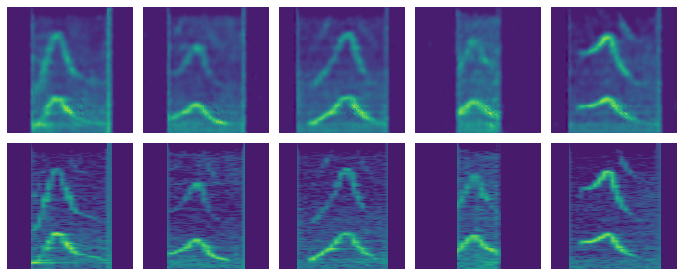

In [212]:
indices = np.random.choice(np.arange(len(dl.dataset)), size=5 ,replace=False)
# Retrieve spectrograms from the loader.
specs_to_test = torch.stack([dl.dataset[ind] for ind in indices]).to(model.device)
# Get resonstructions.
with torch.no_grad():
    _, _, reconstructions = model.forward(specs_to_test, return_latent_rec=True)
    specs_to_test = specs_to_test.detach().cpu().numpy()
    all_images = np.stack([specs_to_test, reconstructions])
    
    #save_filename = os.path.join(self.save_dir, save_filename
    grid_plot(all_images, gap=10, filename='save_filename')

Keys:  ['s', 'e', 'cl', 'rec', 'colony', 'ratids', 'date', 'experiment']
0.07547255440332207
0.07547255440332207


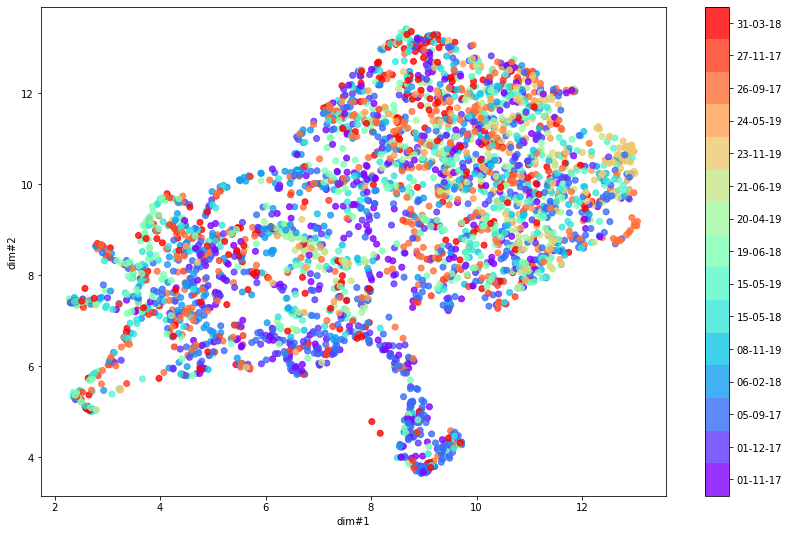

In [141]:

# specify what is ploted
print('Keys: ', list(sounds_metadata.columns))
# specify filters
colonies = ['stark']
weights = 'all'
dates = 'all'
sexes = 'all' 
ages = 'all'
ranks = 'all' 
ratids = 'all'
excludeids = None 
bodylengths = 'all'
bodylengths2 = 'all' 
sounds_per_rat = [0, 10000]
types = 'single'
classes_to_plot = ['loudchirp', 'downsweep', 'grunt', 'whistle',
       'upsweep', 'combotwo', 'mordent', 'pupcombo', 'combo', 'pupsquawk',
       'phee', 'hiccup', 'pupcheveron', 'tweet']
classes_to_plot = ['softchirp', 'sound']
classes_to_drop = ['multipleloudchirps2',]
#classes =  ['combotwo', 'combo', 'downsweep', 'pupcombo', 'grunt', 'loudchirp']
mask =  filter_sounds_metadata_extended(sounds_metadata, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
print(mask.mean())
if classes_to_plot != 'all':
    mask *= sounds_metadata['cl'].isin(classes_to_plot)
if classes_to_drop:
    mask *= ~sounds_metadata['cl'].isin(classes_to_drop)
print(mask.mean())

# how to plot
color_by = 'date'
group_by_rat = False
plot_color_mean = False
group_color_column = None
plot_ellipses = False 

order = ORDER[color_by]
color_dict = COLOR[color_by]

transform = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=42)
embedding = transform.fit_transform(latend_features_scaled[mask])
features_masked = pd.DataFrame(embedding, columns=['dim#1', 'dim#2'])
sounds_metadata_masked = sounds_metadata[mask]
y = sounds_metadata_masked[color_by]


plot(features_masked, y, sounds_metadata_masked, 'all', None, group_by_rat, group_color_column, 
     plot_ellipses, plot_color_mean, color_dict, order, sizes_factor=32)

In [149]:
colonies = ['martell', 'dothrakib', 'arryn', 'stark', 'lannister', 'baratheon', 'targaryen']
for col in colonies:
    p = '/home/nakedmoleratvoices/data/%s/traces/' % col
    print(len(os.listdir(p)))
    

1688
530
852
16401
2856
22774
1969


In [198]:
from sklearn.ensemble import RandomForestRegressor

In [213]:
duration = np.array([len(s)/sr for s in sounds_npy])

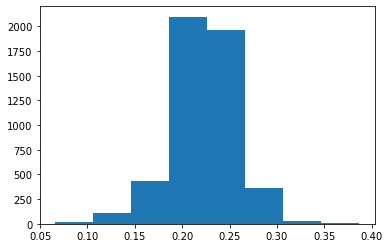

In [217]:
_ = plt.hist(duration, bins=8)

In [226]:
X_train, X_test, y_train, y_test = train_test_split(latent_features, duration,
                                                    test_size=0.2, random_state=42)

In [227]:
ref = RandomForestRegressor(n_estimators=256)
ref.fit(X_train, y_train)

RandomForestRegressor(n_estimators=256)

In [228]:
pred = ref.predict(X_test)
err = np.abs(y_test - pred)
np.mean(err)

0.004588576568687175

In [232]:
ind = np.random.randint(0, len(y_test))
y_test[ind], pred[ind]

(0.19147392290249432, 0.19073944160997805)

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from src.visualization.plotting_utils import plot_confusion_matrix

In [99]:
clf = RandomForestClassifier(n_estimators=256)

In [100]:
y_unique = list(set(y))
y_int = np.array([y_unique.index(yi) for yi in y])
X = latend_features_scaled[mask]
represented_classes_int = np.where(np.bincount(y_int) > 50)[0]
balance_inds = [ind for ind in range(len(y)) if y_int[ind] in represented_classes_int]
X_train, X_test, y_train, y_test = train_test_split(X[balance_inds], y_int[balance_inds],
                                                    test_size=0.2, random_state=42)

In [101]:
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

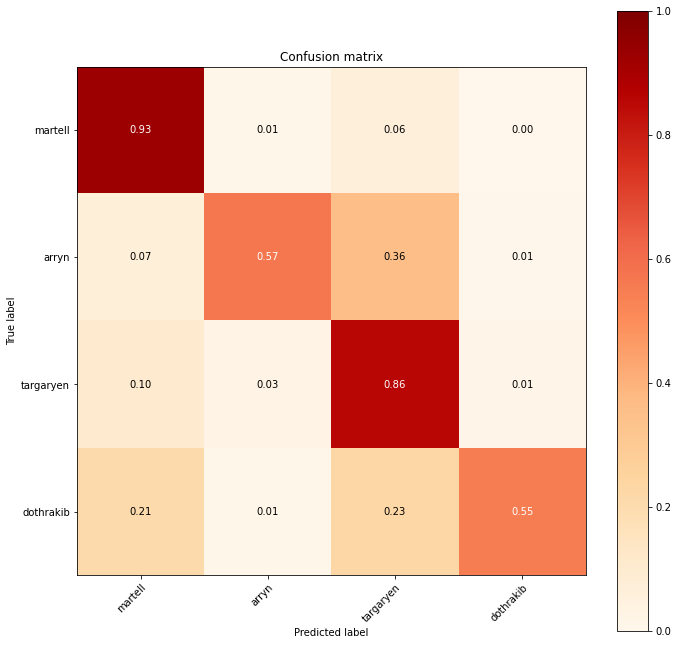

In [102]:
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm, y_unique)


TRAIN SET:
{'targaryen': 370, 'arryn': 312, 'martell': 282, 'dothrakib': 244}
{'4075': 160, '4057': 139, '88': 102, '9435': 100, '1544': 100, '9469': 71, '9438': 44, '4055': 40, '9458': 39, '3317': 37, '3306': 33, '3313': 29, '1574': 27, '3321': 25, '3320': 25, '8513': 25, '1411': 24, '4061': 23, '3311': 22, '1472': 22, '3318': 19, '4038': 17, '1488': 16, '3513': 15, '3305': 13, '3302': 12, '3309': 11, '3324': 9, '3303': 9}

TEST SET:
{'dothrakib': 286, 'martell': 248, 'arryn': 218, 'targaryen': 160}
{'3523': 95, '9442': 73, '9423': 55, '827': 49, '3481': 44, '9624': 41, '4073': 40, '3307': 34, '3301': 34, '3980': 32, '55': 32, '3310': 30, '3308': 29, '3304': 29, '4072': 28, '545': 27, '4327': 25, '3312': 23, '3315': 21, '3319': 20, '1536': 19, '3325': 18, '3323': 17, '1222': 16, '1520': 16, '3322': 14, '3314': 14, '1540': 14, '4030': 13, '1523': 7, '3316': 3}

TRAIN SET:
{'dothrakib': 286, 'martell': 248, 'arryn': 218, 'targaryen': 160}
{'3523': 95, '9442': 73, '9423': 55, '827': 49,

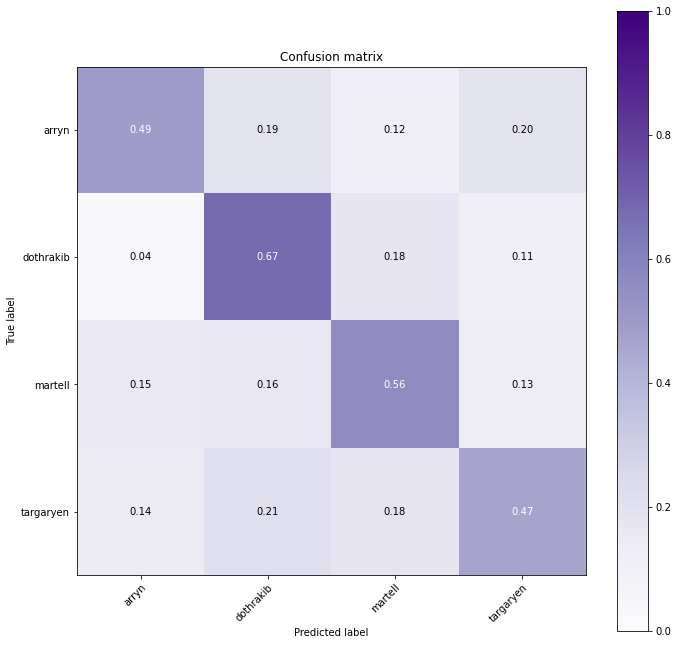

In [104]:
from src.data_analysis.softchirps_classification import classify
features_df = pd.DataFrame(latend_features_scaled)
clf, foster_probs, y_unique, y_unique_foster = classify(features_df, sounds_metadata, mask, 
                                                        np.zeros_like(mask), 
                                                        ORDER['colony'], 'colony',  'all', 'ratids',
                                                        True, 2, False, True,)

(201,)
pupcheveron
scream
scream


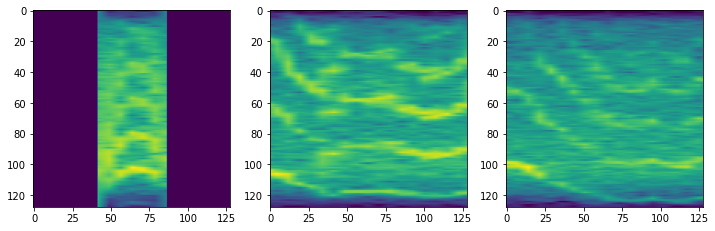

In [88]:
# Examples from a region
X_AXIS_RANGE = (8, 10)
Y_AXIS_RANGE = (-2, 9)
plot_rectangle(X_AXIS_RANGE, Y_AXIS_RANGE, embedding,  sounds_metadata_masked, specs)

(132,)
softchirp
softchirp
softchirp


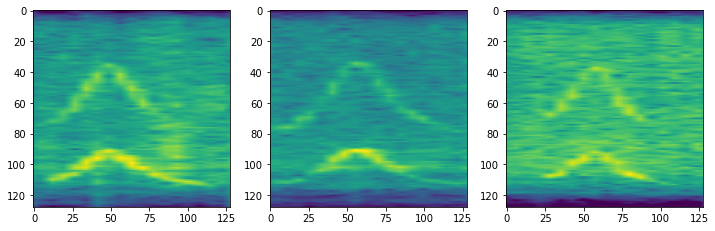

In [58]:
# Examples from a region
X_AXIS_RANGE = (-10, 5)
Y_AXIS_RANGE = (0, 12)
plot_rectangle(X_AXIS_RANGE, Y_AXIS_RANGE, embedding,  sounds_metadata_masked, specs)

In [ ]:
X_AXIS_RANGE = (9, 11)
Y_AXIS_RANGE = (-2, 0)
plot_rectangle(X_AXIS_RANGE, Y_AXIS_RANGE, embedding,  sounds_metadata_masked, spec_train_aug)

In [ ]:
%matplotlib inline
#assert num_specs <= len(loader.dataset) and num_specs >= 1
#indices = np.random.choice(np.arange(len(dl.dataset)), size=5 ,replace=False)
indices = np.random.choice(np.where(mask)[0], size=5, replace=False)
# Retrieve spectrograms from the loader.
specs = torch.stack([dl_test.dataset[ind] for ind in indices]).to(model.device)
# Get resonstructions.
with torch.no_grad():
    _, _, rec_specs = model.forward(specs, return_latent_rec=True)
    specs = specs.detach().cpu().numpy()
    all_specs = np.stack([specs, rec_specs])
    
    #save_filename = os.path.join(self.save_dir, save_filename
    grid_plot(all_specs, gap=1, filename='save_filename')
